In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
from tqdm.notebook import tnrange

In [2]:
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Code

## Class: Normal Distribution Bandit Test Bed

In [174]:
class NormalTestbed:
    """Return random value according to expected value config
    
    Attributes:
        expected_values (dict): dict of mean and var of each arm in the testbed
        Example:
            expected_values = {1: {'mean': 0.5, 'var': 1}, 2: {'mean': 1, 'var': 1}}
    """
    
    def __init__(self, expected_values, p_drift=0, p_mag=1):
        self.expected_values = expected_values
        self.p_drift=p_drift
        self.p_mag=p_mag
        
    def action_value(self, action, shape=None):
        if np.random.binomial(1, self.p_drift) == 1:
            A_drift = np.random.choice(list(self.expected_values.keys()))
            self.expected_values[A_drift]['mean'] = self.expected_values[A_drift]['mean'] + (np.random.random()-0.5)   
        
        return np.random.normal(loc=self.expected_values[action]['mean'], 
                                scale=self.expected_values[action]['var'],
                                size=shape)
    
    def estimate_distribution(self, n=1000):
        R = pd.DataFrame(columns=['Reward', 'Action', 'Strategy'])
        for a in self.expected_values:
            Ra = pd.DataFrame(self.action_value(a, shape=(n, 1)), columns=['Reward'])
            Ra['Action'] = a
            Ra['Strategy'] = 'uniform'
            R = pd.concat([R, Ra])
        return R        

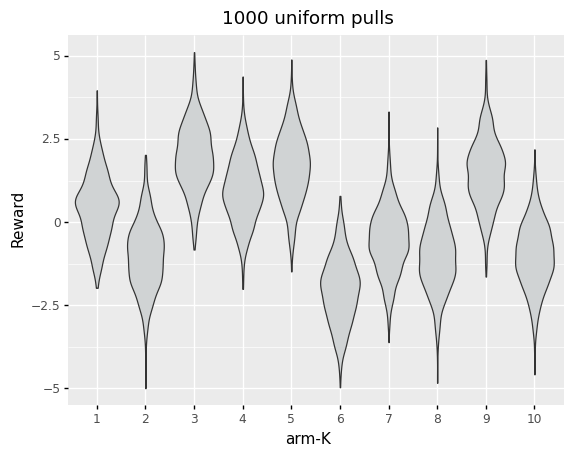

<ggplot: (8740658656725)>

In [124]:
N = 1000
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)
Ru = testbed.estimate_distribution()

(
    p9.ggplot(Ru, p9.aes(x='factor(Action)', y='Reward'))
    + p9.geom_violin(fill='#d0d3d4')
    + p9.xlab('arm-K')
    + p9.ylab('Reward')
    + p9.ggtitle(f'{N} uniform pulls')
)



## Function: Realistic Initialization

In [69]:
def init_realistic(testbed, n=1):
    R = pd.DataFrame(columns=['Reward', 'Action', 't'])
    for a in testbed.expected_values:
        Ra = pd.DataFrame({'Reward': [testbed.action_value(a) for i in range(n)], 
                           'Action': [a for i in range(n)],
                           't': [0 for i in range(n)],
                          })
        R = pd.concat([R, Ra])        
    return R.groupby('Action').mean().to_dict()['Reward']

## Function: Constant Initialization

In [64]:
def init_constant(testbed, init_val):

    return {a: init_val for a in testbed.expected_values}

## Function: Greedy Bandit

In [67]:
def greedy_pull(testbed, n=1000):
    Q = init_realistic(testbed)
    At = list(Q.keys())[np.argmax(np.array(list(Q.values())))]
    R = pd.DataFrame.from_dict(Q, columns=['Reward'], orient='index').reset_index().rename(columns={'index': 'Action'})

    for i in range(n-len(testbed.expected_values.keys())):
        Ra = pd.DataFrame({'Reward': [testbed.action_value(At)], 'Action': [At]})
        R = pd.concat([R, Ra])
        Q = R.groupby('Action').mean().to_dict()['Reward']
        At = list(Q.keys())[np.argmax(np.array(list(Q.values())).astype(float))]
        
    return R

In [149]:
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Rg = greedy_pull(testbed, n=1000)

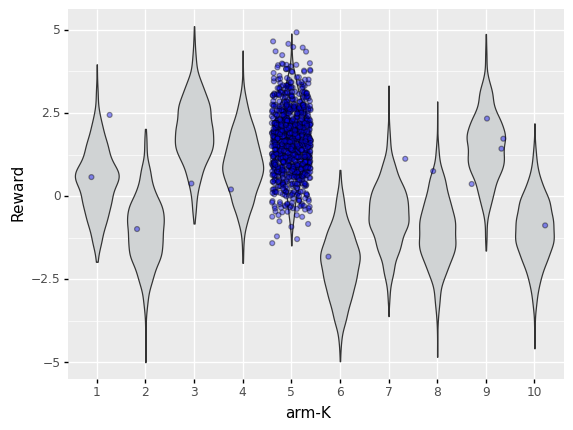

<ggplot: (8740642562649)>

In [150]:
(
    p9.ggplot(Ru, p9.aes(x='factor(Action)', y='Reward'))
    + p9.xlab('arm-K')
    + p9.ylab('Reward')
    + p9.geom_violin(fill='#d0d3d4')
    + p9.geom_jitter(Rg, alpha=0.4, fill='blue')

)

## Function: Epsilon Greedy Bandit

In [211]:
def argmax(Q):
    Q_array = np.array(list(Q.values()))
    At = np.argwhere(Q_array == np.max(Q_array)).flatten().tolist()
    
    if len(At) > 1:
        At = np.random.choice(At)
    else:
        At = At[0]
    
    return list(Q.keys())[At]


def epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1):
    At = argmax(Q)
    R = pd.DataFrame.from_dict(Q, columns=['Reward'], orient='index').reset_index().rename(columns={'index': 'Action'})
    R['epsilon'] = epsilon
    R['t'] = 0
    
    for i in range(1, n+1):
        Ra = pd.DataFrame({'Reward': [testbed.action_value(At)], 'Action': [At], 't': [i], 'epsilon': [epsilon]})
        R = pd.concat([R, Ra])
        Q = R.groupby('Action').mean().to_dict()['Reward']
        if np.random.binomial(1, epsilon) == 1:
            At = np.random.choice(list(Q.keys()))
        else:
            At = argmax(Q)
            
    R['Average Reward'] = R['Reward'].expanding().mean()
    
    return R


def epsilon_greedy_optimized(testbed, Q, n=1000, epsilon=0.1):
    At = argmax(Q)
    df_R = pd.DataFrame.from_dict(Q, columns=['Reward'], orient='index').reset_index().rename(columns={'index': 'Action'})
    df_R['epsilon'] = epsilon
    df_R['t'] = 0
    nQ = {a: 0 for a in Q}
    
    for i in range(1, n+1):
        R = testbed.action_value(At)
        df_Ra = pd.DataFrame({'Reward': [R], 'Action': [At], 't': [i], 'epsilon': [epsilon]})
        df_R = pd.concat([df_R, df_Ra])
        
        if np.random.binomial(1, epsilon) == 1:
            At = np.random.choice(list(Q.keys()))
        else:
            At = argmax(Q)
        
        nQ[At] += 1 
        Q[At] = Q[At] + 1/nQ[At]*(R-Q[At])
    
    return df_R

In [225]:
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Q = init_realistic(testbed, n=1)
%time R1 = epsilon_greedy_pull(testbed, Q, n=10000, epsilon=0)
%time R2 = epsilon_greedy_optimized(testbed, Q, n=10000, epsilon=0)

CPU times: user 24.4 s, sys: 120 ms, total: 24.5 s
Wall time: 24.6 s
CPU times: user 12.6 s, sys: 0 ns, total: 12.6 s
Wall time: 12.6 s


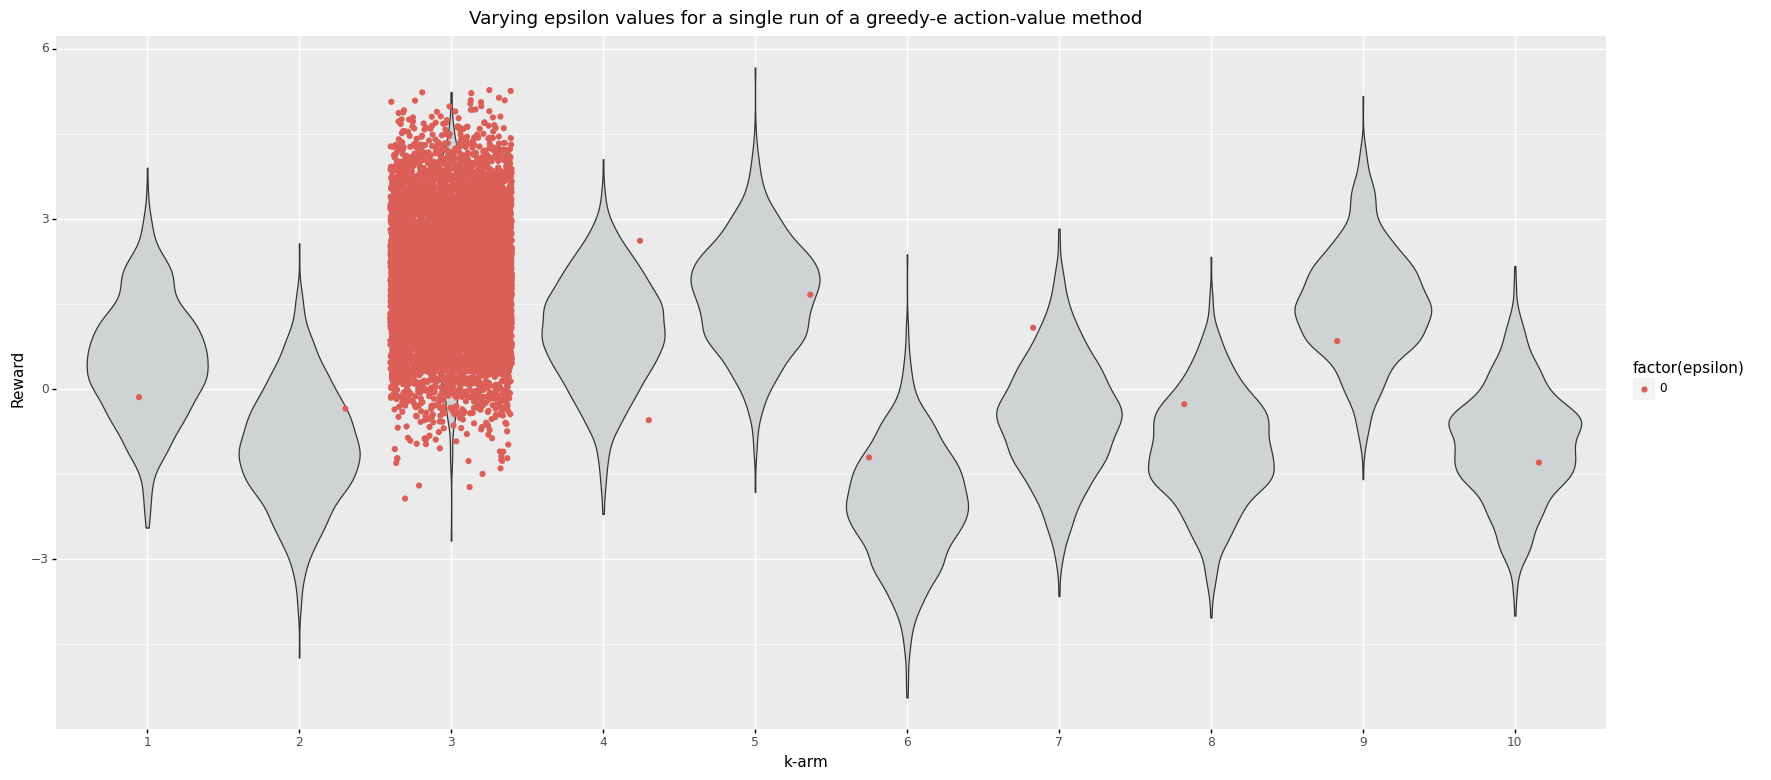

<ggplot: (8740642972321)>

In [226]:
(
    p9.ggplot(p9.aes(x='factor(Action)', y='Reward',))
    + p9.ggtitle('Varying epsilon values for a single run of a greedy-e action-value method')
    + p9.xlab('k-arm')
    + p9.ylab('Reward')
    + p9.geom_violin(testbed.estimate_distribution(), fill='#d0d3d4')
    + p9.geom_jitter(R1, p9.aes(color='factor(epsilon)'))
    + p9.theme(figure_size=(20,9))
)

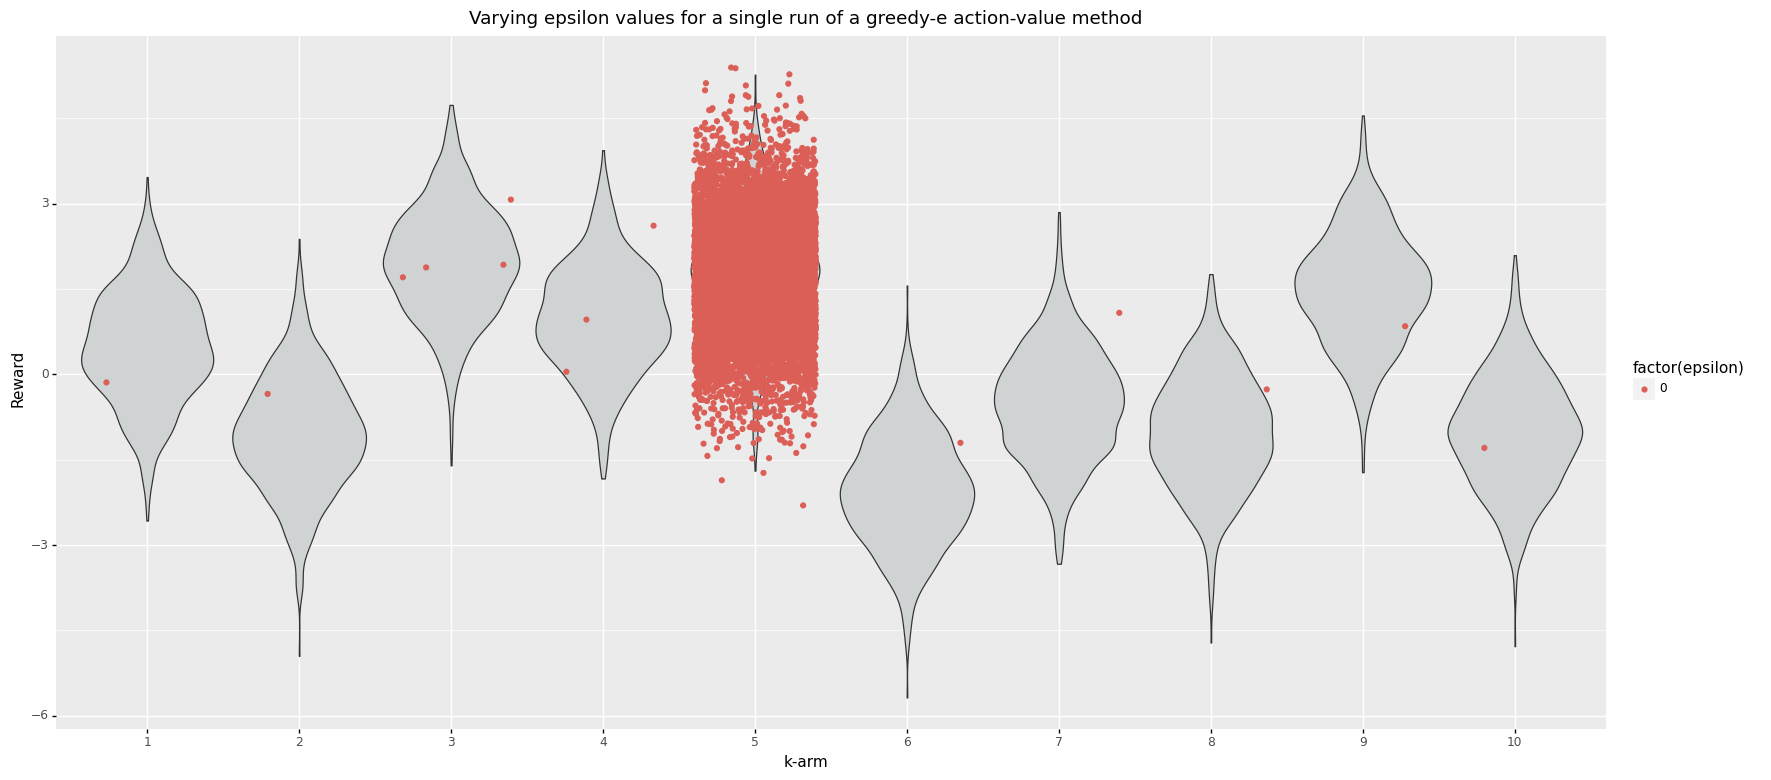

<ggplot: (8740643117053)>

In [227]:
(
    p9.ggplot(p9.aes(x='factor(Action)', y='Reward',))
    + p9.ggtitle('Varying epsilon values for a single run of a greedy-e action-value method')
    + p9.xlab('k-arm')
    + p9.ylab('Reward')
    + p9.geom_violin(testbed.estimate_distribution(), fill='#d0d3d4')
    + p9.geom_jitter(R2, p9.aes(color='factor(epsilon)'))
    + p9.theme(figure_size=(20,9))
)

# Results

In [151]:
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Q = init_realistic(testbed, n=1)
Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

R = pd.concat([Re0, Re01, Re10])

### Results: Distribution of a single e-greedy run across different epsilons using realistic init

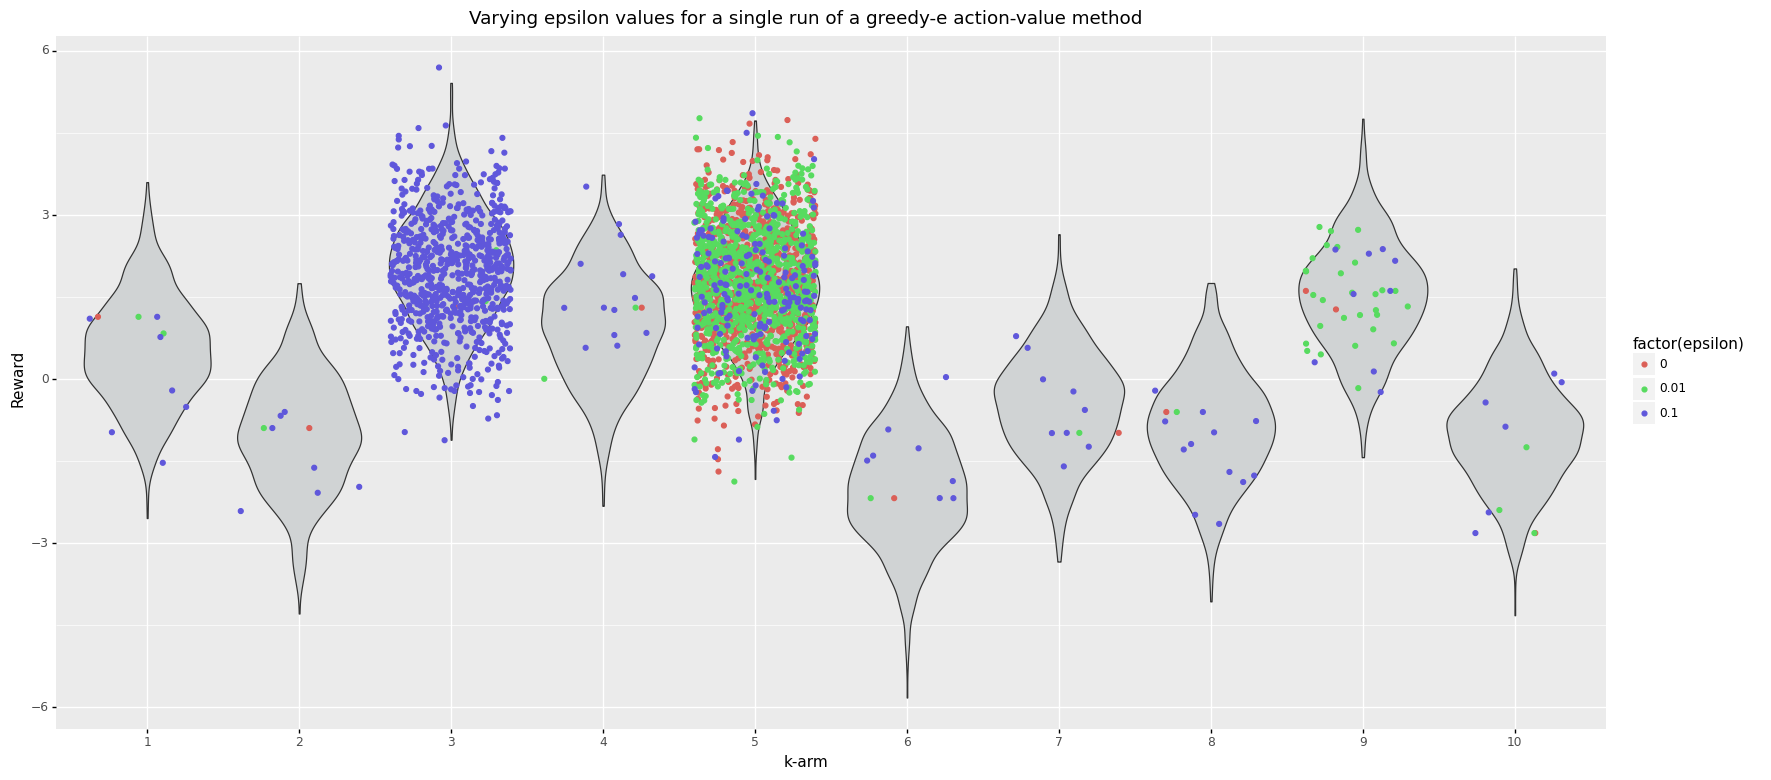

<ggplot: (8740643238157)>

In [152]:
(
    p9.ggplot(p9.aes(x='factor(Action)', y='Reward',))
    + p9.ggtitle('Varying epsilon values for a single run of a greedy-e action-value method')
    + p9.xlab('k-arm')
    + p9.ylab('Reward')
    + p9.geom_violin(testbed.estimate_distribution(), fill='#d0d3d4')
    + p9.geom_jitter(R, p9.aes(color='factor(epsilon)'))
    + p9.theme(figure_size=(20,9))
)

### Results: Average rewards across time steps for a single e-greedy run for different epsilons using realistic init

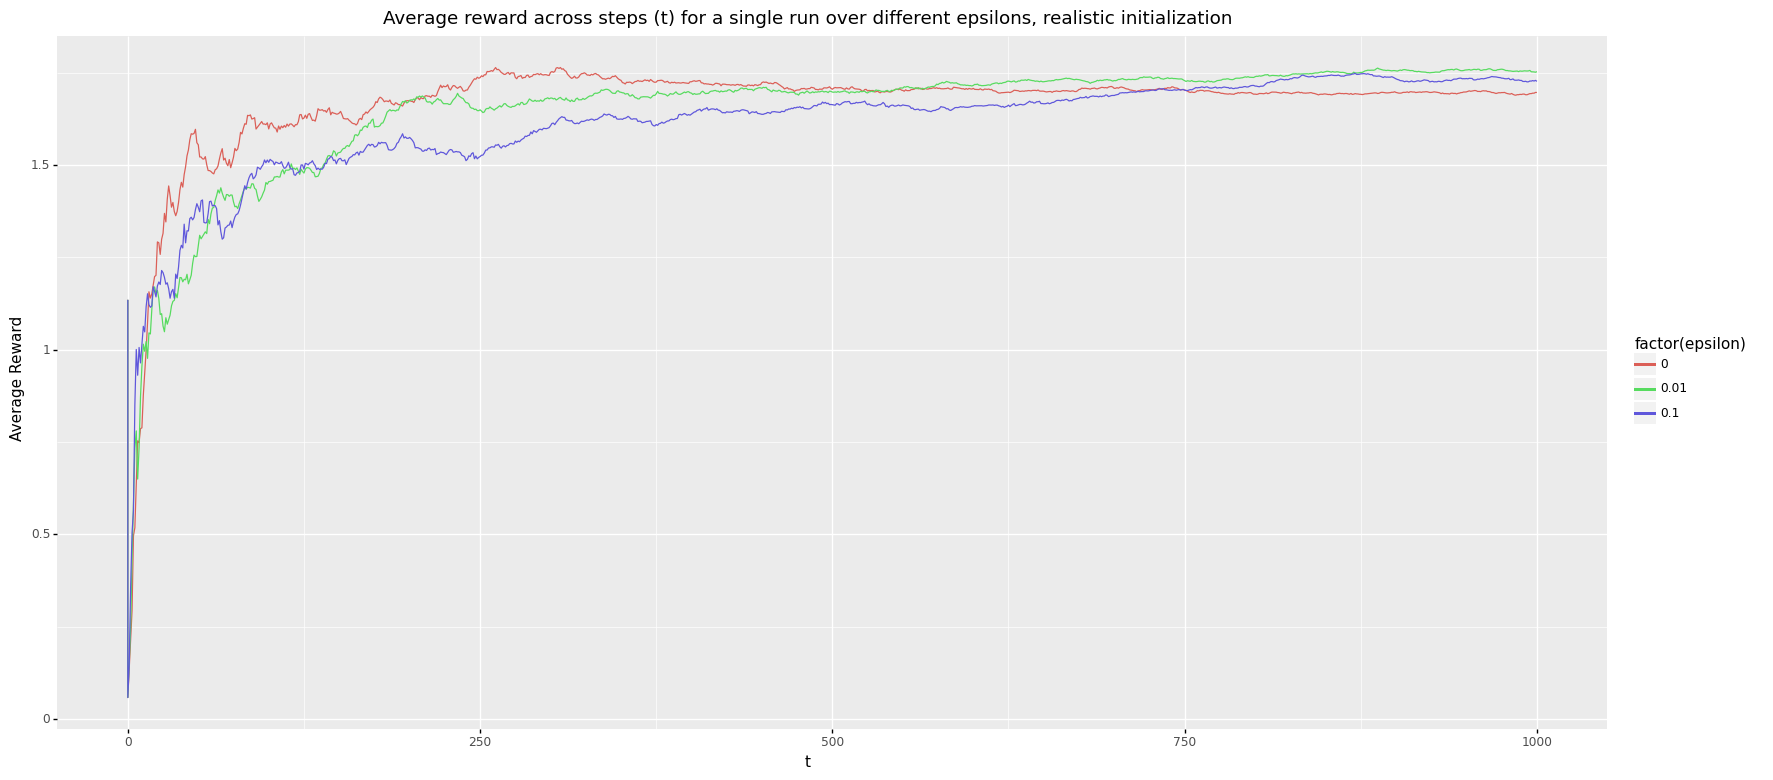

<ggplot: (8740643115753)>

In [153]:
# Time steps across single run
(
    p9.ggplot(R, p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle('Average reward across steps (t) for a single run over different epsilons, realistic initialization')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [154]:
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Q = init_constant(testbed, 3)
Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

R = pd.concat([Re0, Re01, Re10])

### Results: Distribution of a single e-greedy run across different epsilons using optimistic init

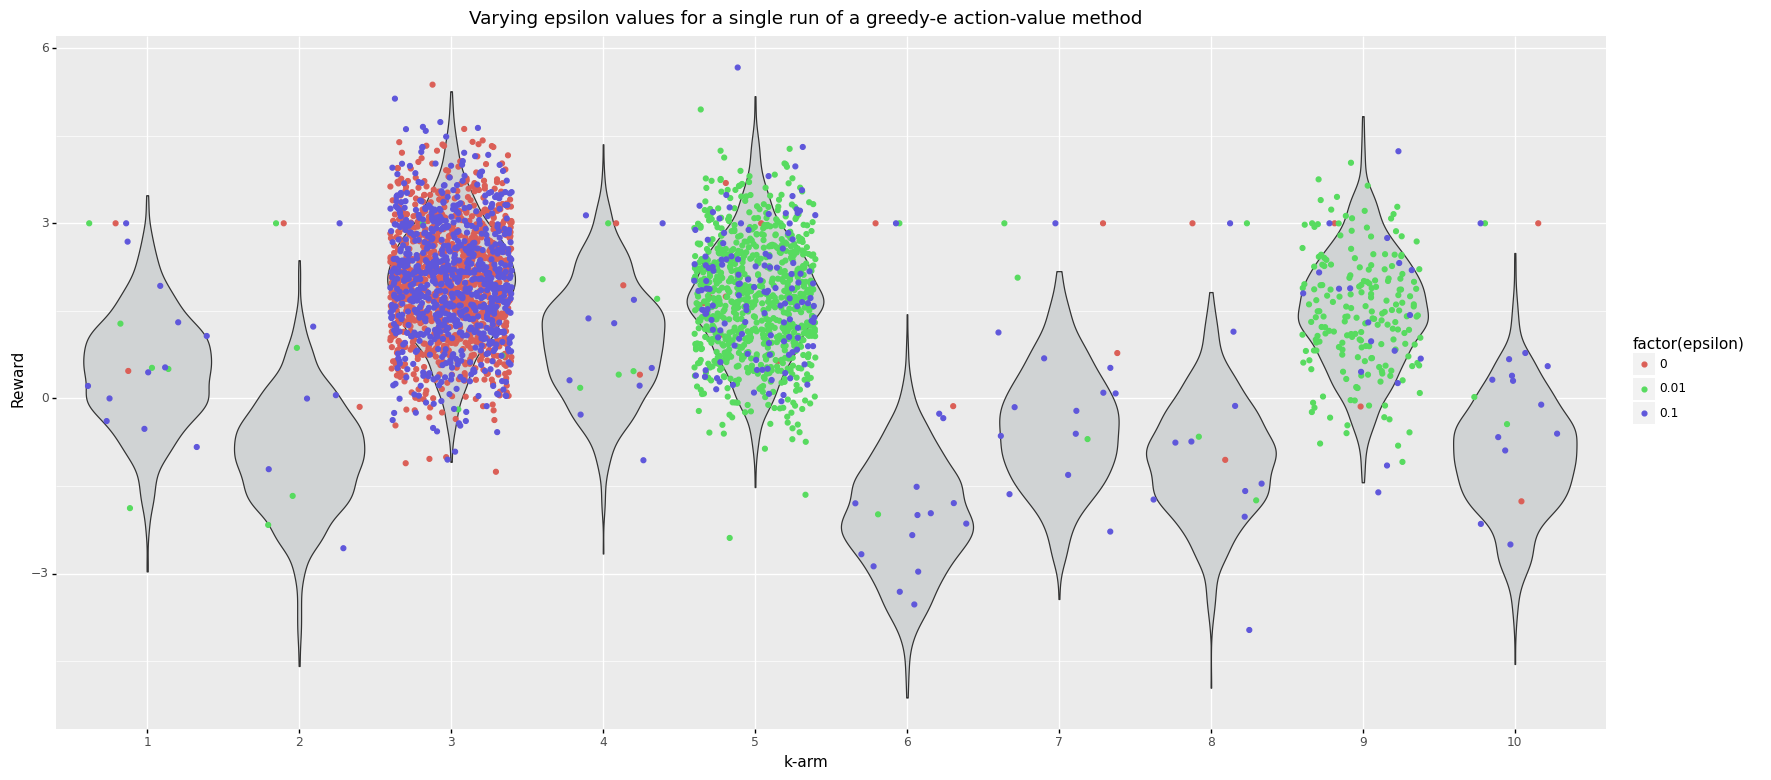

<ggplot: (8740657417501)>

In [155]:
(
    p9.ggplot(p9.aes(x='factor(Action)', y='Reward',))
    + p9.ggtitle('Varying epsilon values for a single run of a greedy-e action-value method')
    + p9.xlab('k-arm')
    + p9.ylab('Reward')
    + p9.geom_violin(testbed.estimate_distribution(), fill='#d0d3d4')
    + p9.geom_jitter(R, p9.aes(color='factor(epsilon)'))
    + p9.theme(figure_size=(20,9))
)

### Results: Average rewards across time steps for a single e-greedy run for different epsilons using optimistic init

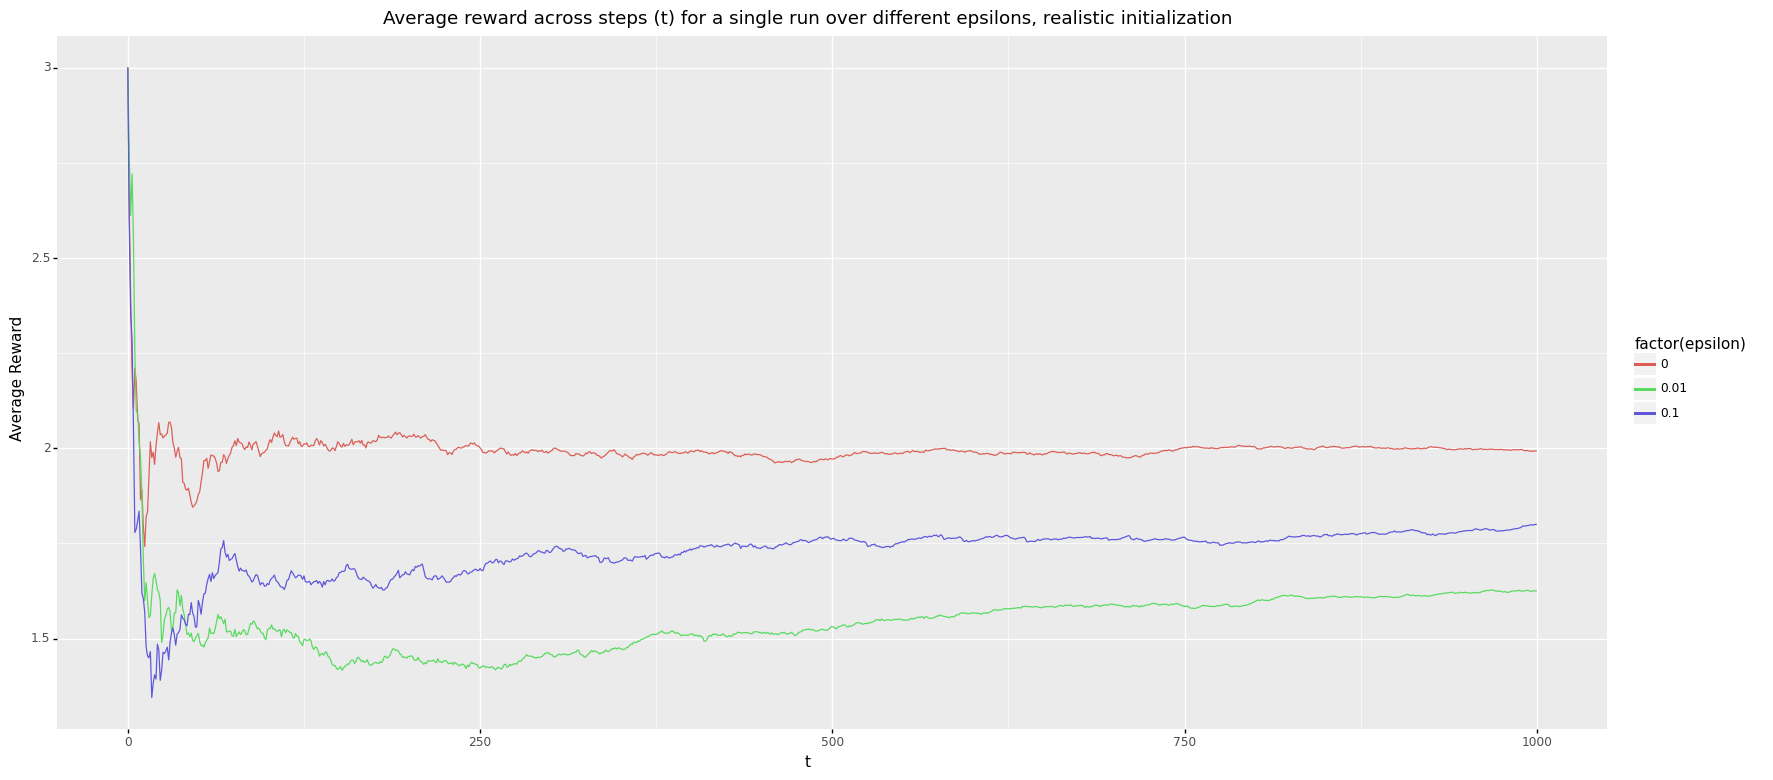

<ggplot: (8740642974989)>

In [156]:
# Time steps across single run
(
    p9.ggplot(R, p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle('Average reward across steps (t) for a single run over different epsilons, realistic initialization')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [157]:
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Q = init_constant(testbed, 0)
Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

R = pd.concat([Re0, Re01, Re10])

### Results: Distribution of a single e-greedy run across different epsilons using 0 init

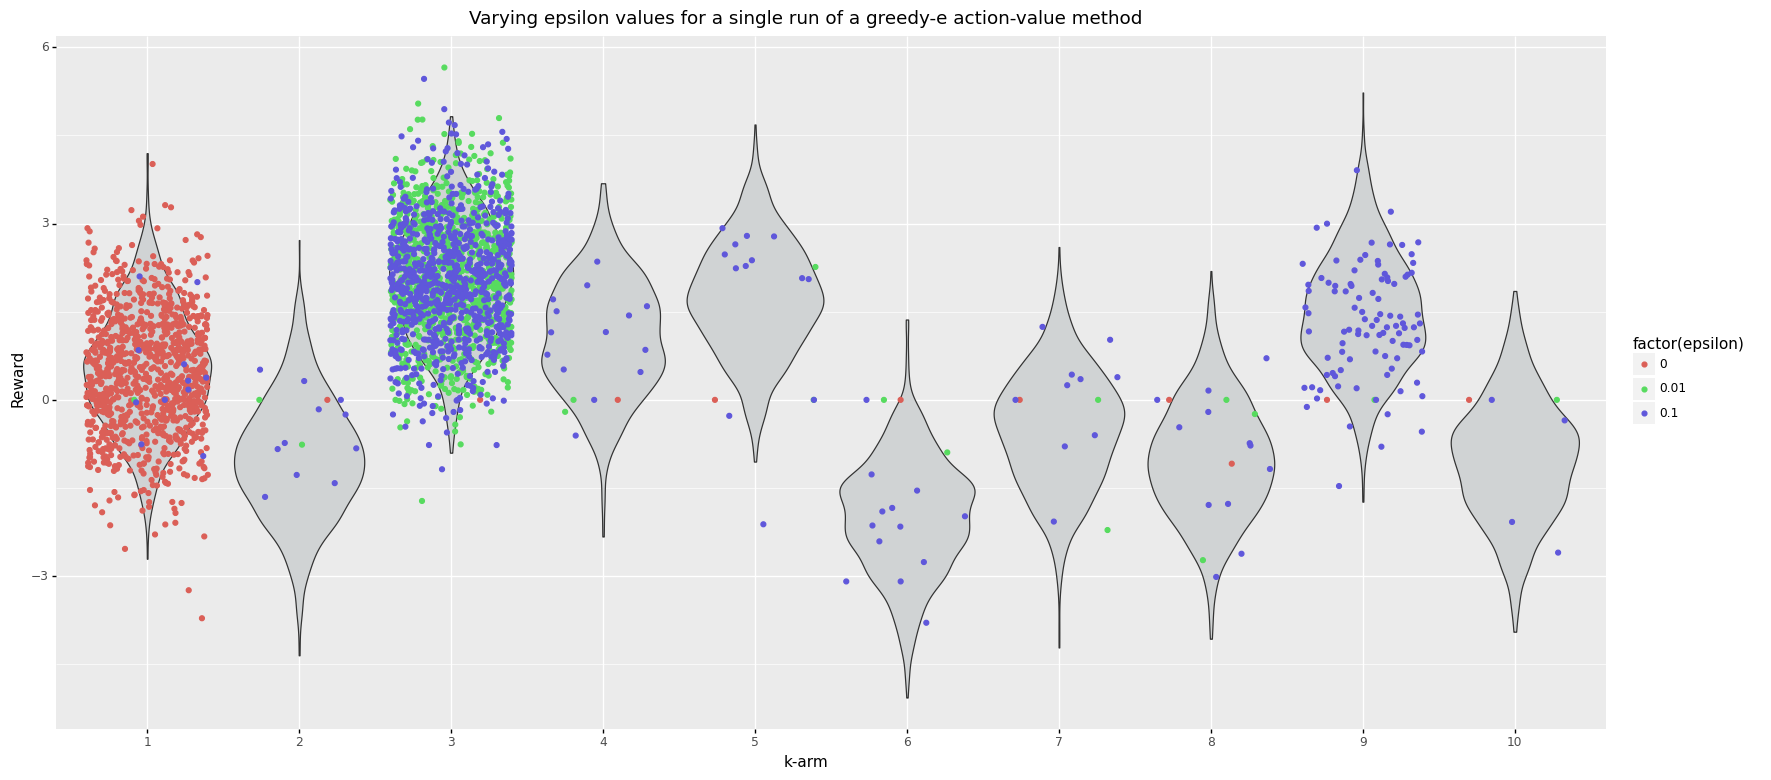

<ggplot: (8740657424889)>

In [158]:
(
    p9.ggplot(p9.aes(x='factor(Action)', y='Reward',))
    + p9.ggtitle('Varying epsilon values for a single run of a greedy-e action-value method')
    + p9.xlab('k-arm')
    + p9.ylab('Reward')
    + p9.geom_violin(testbed.estimate_distribution(), fill='#d0d3d4')
    + p9.geom_jitter(R, p9.aes(color='factor(epsilon)'))
    + p9.theme(figure_size=(20,9))
)

### Results: Average rewards across time steps for a single e-greedy run for different epsilons using 0 init

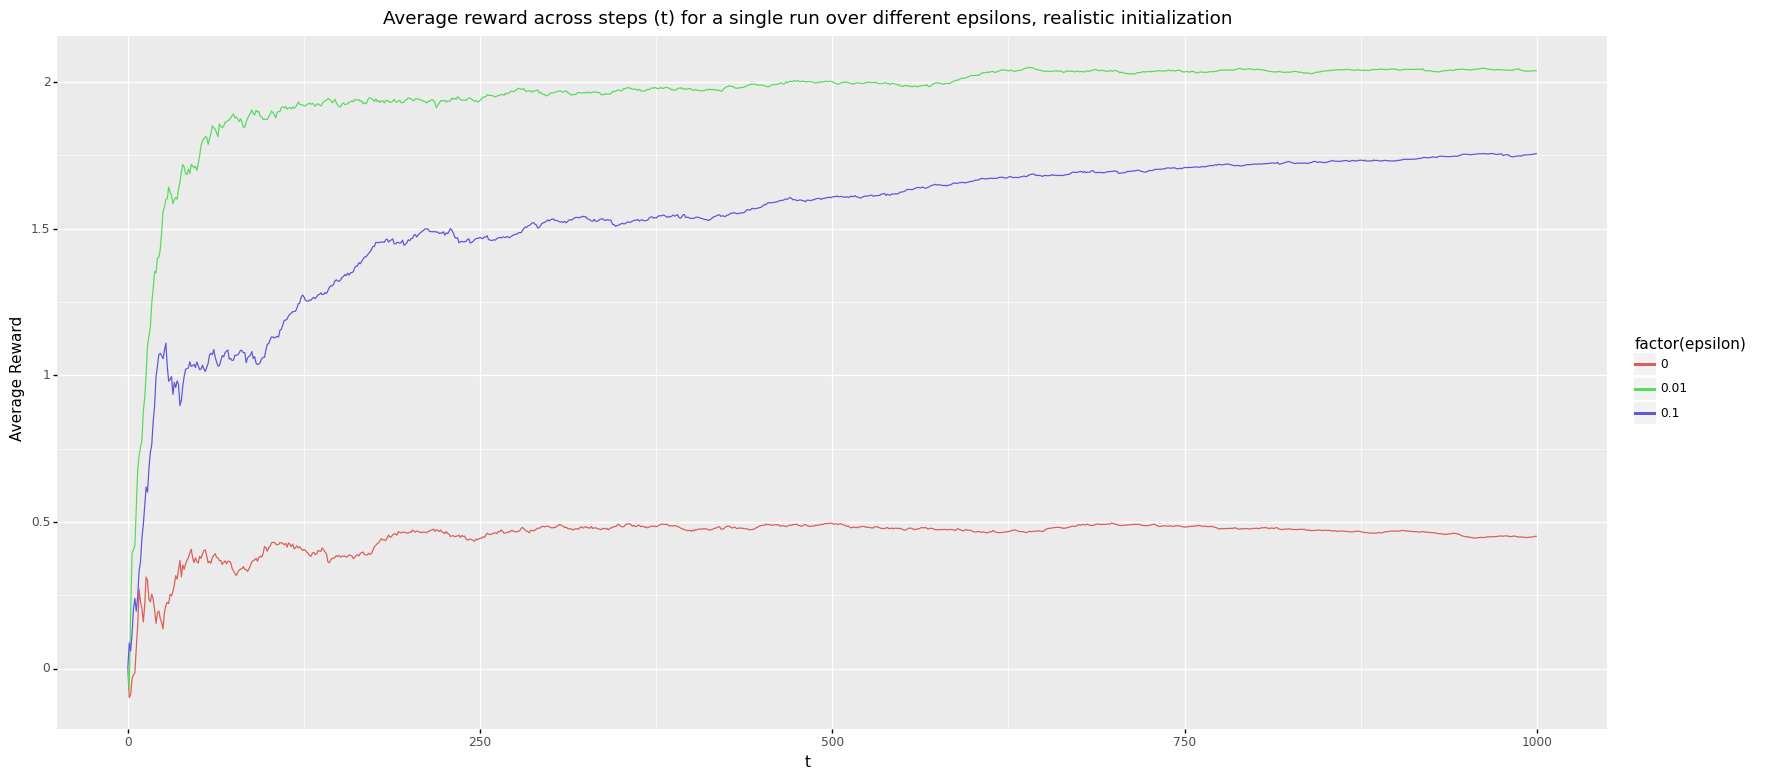

<ggplot: (8740642325093)>

In [159]:
# Time steps across single run
(
    p9.ggplot(R, p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle('Average reward across steps (t) for a single run over different epsilons, realistic initialization')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [163]:
# Multiple runs, realistic init
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
for i in tnrange(RUNS, desc='i runs'):
    Q = init_realistic(testbed, n=1)
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    R['run'] = i
    Ri = pd.concat([R, Ri])

In [164]:
Ri_mean = Ri.groupby(['t', 'epsilon']).mean('Average Reward')
Ri.groupby(['t', 'epsilon']).mean('Average Reward').iloc[-18:, :]

Reward  Average Reward
t    epsilon                          
995  0.00     2.041436        1.806950
     0.01     1.795826        1.867965
     0.10     1.715415        1.741799
996  0.00     1.973343        1.807115
     0.01     1.899768        1.867997
     0.10     1.774667        1.741832
997  0.00     1.732632        1.807042
     0.01     1.924755        1.868053
     0.10     1.737457        1.741828
998  0.00     1.865846        1.807100
     0.01     1.754826        1.867941
     0.10     1.735731        1.741822
999  0.00     1.935090        1.807227
     0.01     2.022105        1.868093
     0.10     1.805159        1.741884
1000 0.00     1.869449        1.807288
     0.01     1.822061        1.868048
     0.10     1.677788        1.741821

### Results: Average rewards across time steps for 100 e-greedy runs at different epsilons using realistic init

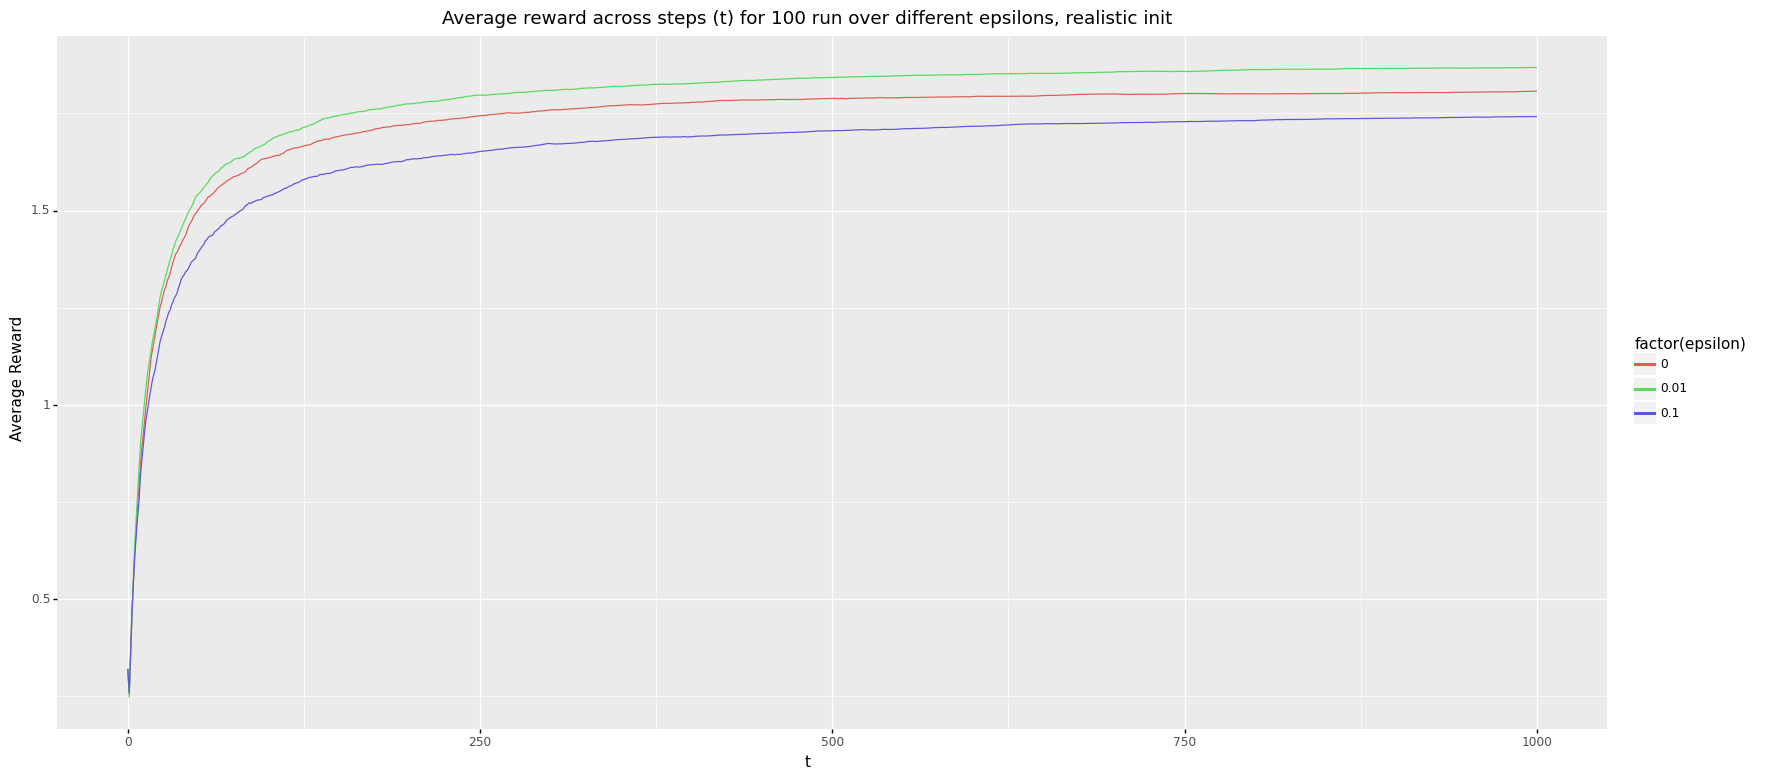

<ggplot: (8740648790613)>

In [165]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, realistic init')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [166]:
# Multiple runs, realistic init
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
Q = init_constant(testbed, 0)
for i in tnrange(RUNS, desc='i runs'):
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    R['run'] = i
    Ri = pd.concat([R, Ri])

In [167]:
Ri_mean = Ri.groupby(['t', 'epsilon']).mean('Average Reward')

### Results: Average rewards across time steps for 100 e-greedy runs at different epsilons using 0 init

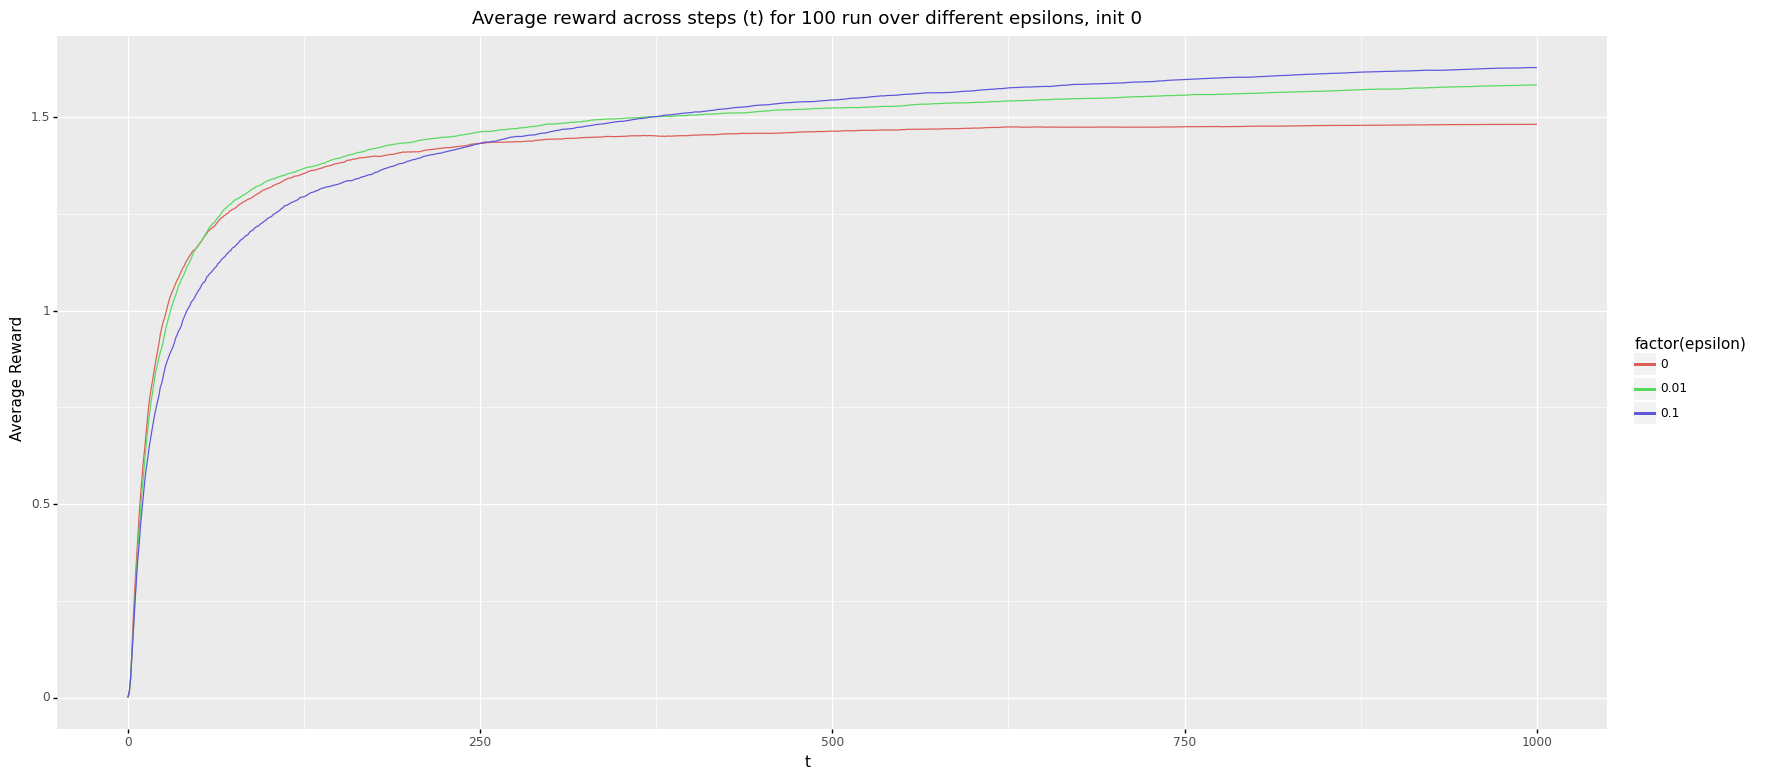

<ggplot: (8740642802429)>

In [168]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, init 0')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [169]:
# Multiple runs, optimistic init
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
Q = init_constant(testbed, 3)
for i in tnrange(RUNS, desc='i runs'):
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    R['run'] = i
    Ri = pd.concat([R, Ri])

In [170]:
Ri_mean = Ri.loc[Ri.t != 0].groupby(['t', 'epsilon']).mean('Average Reward')

### Results: Average rewards across time steps for 100 e-greedy runs at different epsilons using optimistic init

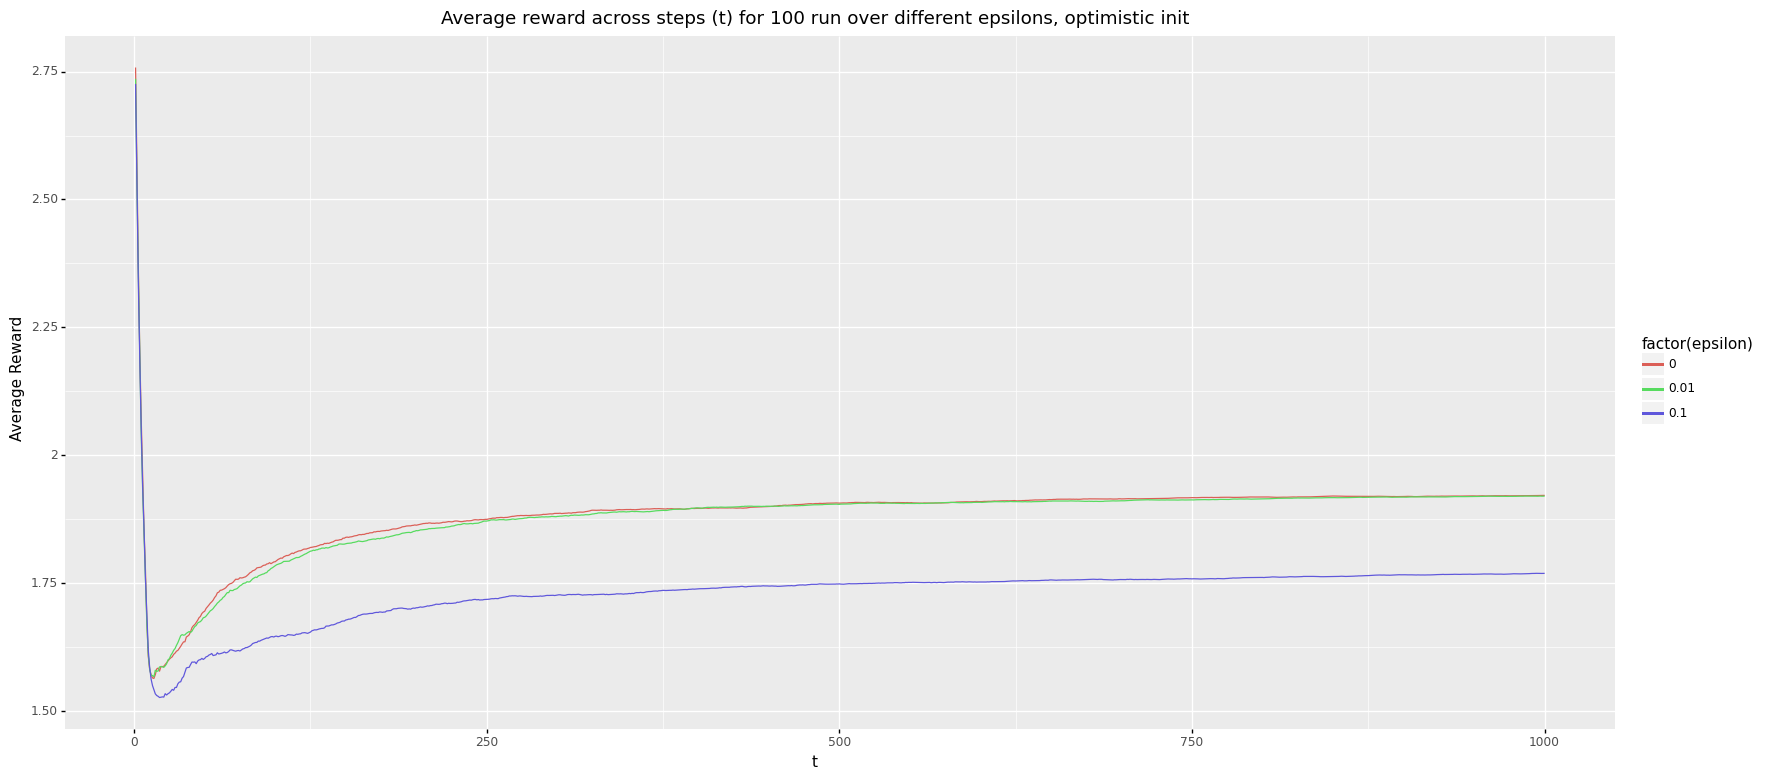

<ggplot: (8740642802265)>

In [171]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, optimistic init')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [175]:
# Multiple runs, optimistic init, with drift p = 0.1
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values, p_drift=0.1)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
Q = init_constant(testbed, 3)
for i in tnrange(RUNS, desc='i runs'):
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    R['run'] = i
    Ri = pd.concat([R, Ri])

In [176]:
Ri_mean = Ri.loc[Ri.t != 0].groupby(['t', 'epsilon']).mean('Average Reward')

### Results: Average rewards across time steps for 100 e-greedy runs at different epsilons using optimistic init - non-stationary test bed

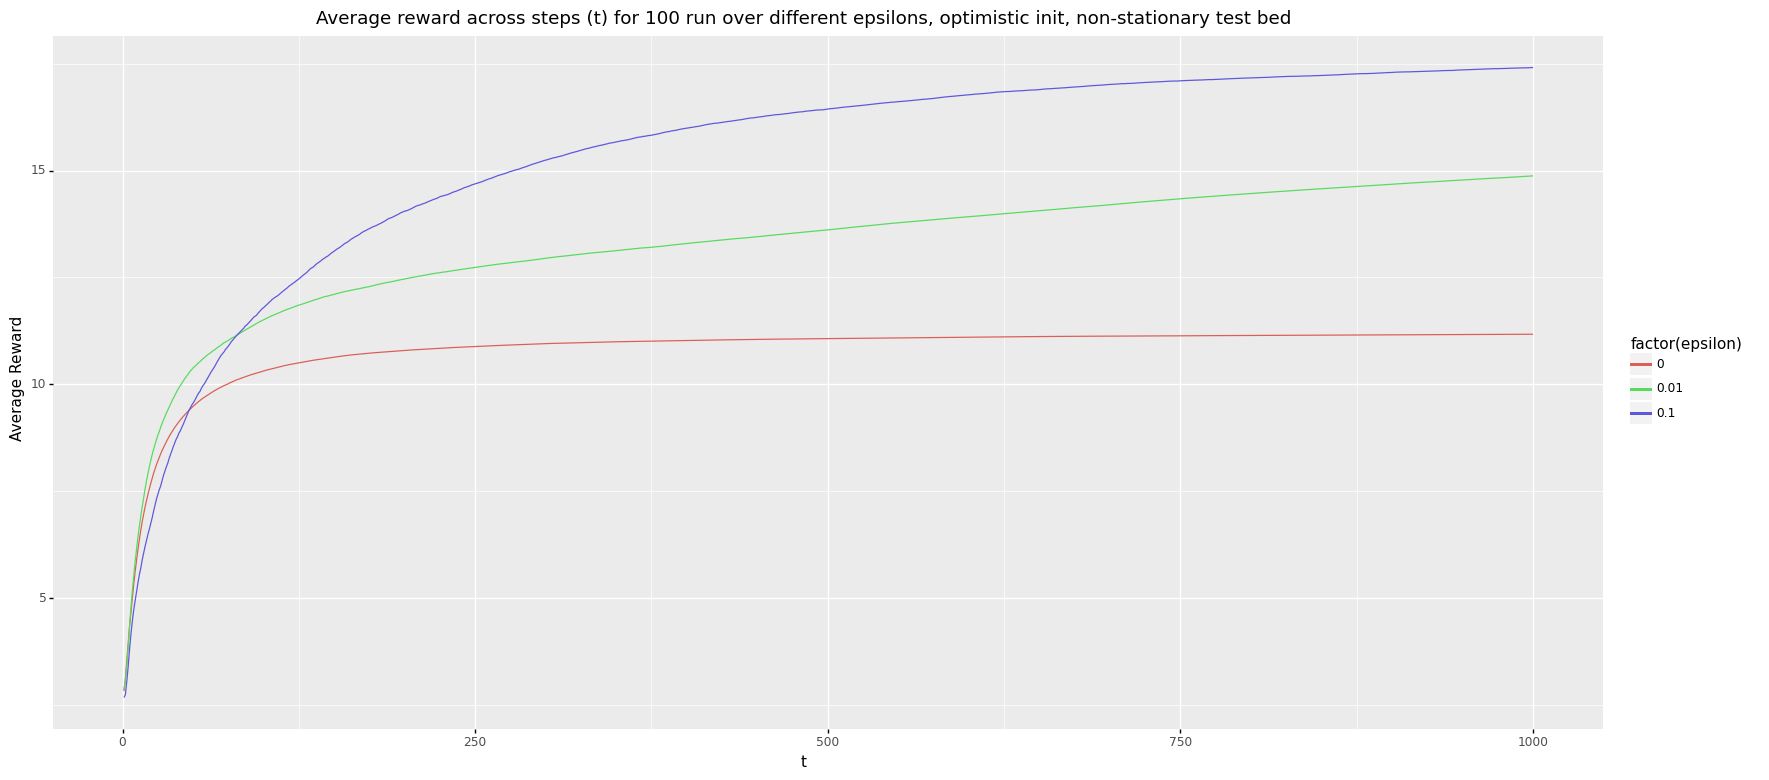

<ggplot: (8740642230793)>

In [177]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, optimistic init, non-stationary test bed')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [178]:
# Multiple runs, realistic init, with drift p = 0.1
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values, p_drift=0.1)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
Q = init_realistic(testbed)
for i in tnrange(RUNS, desc='i runs'):
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    R['run'] = i
    Ri = pd.concat([R, Ri])

Ri_mean = Ri.loc[Ri.t != 0].groupby(['t', 'epsilon']).mean('Average Reward')

### Results: Average rewards across time steps for 100 e-greedy runs at different epsilons using realistic init - non-stationary test bed

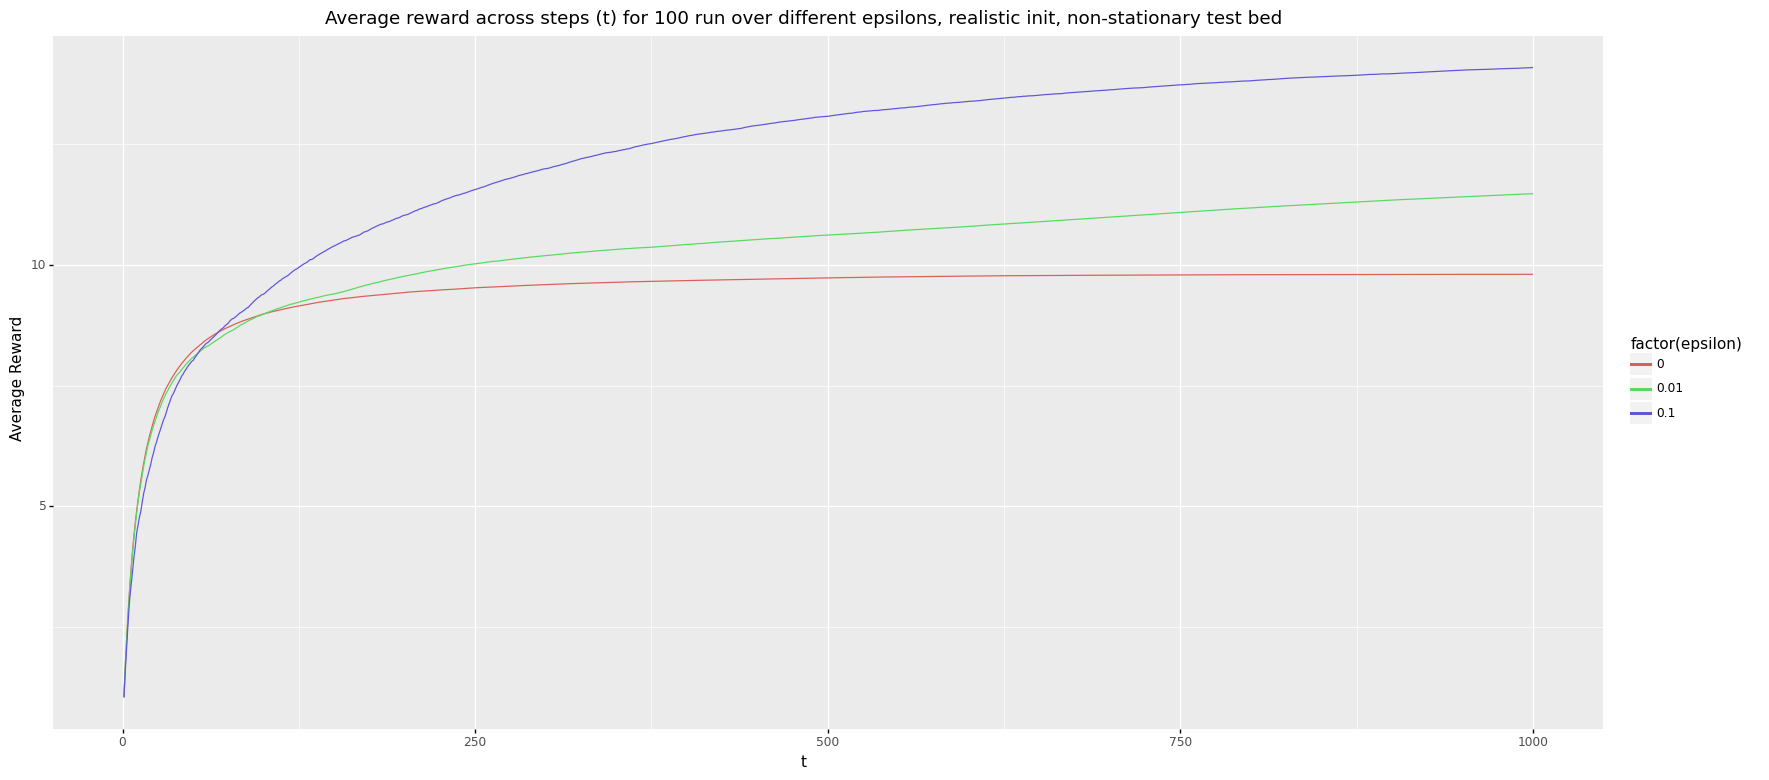

<ggplot: (8740642226973)>

In [179]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, realistic init, non-stationary test bed')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [180]:
testbed.expected_values

{1: {'mean': 15.817869225382744, 'var': 1},
 2: {'mean': -28.977498587822335, 'var': 1},
 3: {'mean': 4.63045455930066, 'var': 1},
 4: {'mean': -29.958416763684127, 'var': 1},
 5: {'mean': -11.645599052384618, 'var': 1},
 6: {'mean': -26.51989940464445, 'var': 1},
 7: {'mean': 13.009077796320497, 'var': 1},
 8: {'mean': -19.99214514693986, 'var': 1},
 9: {'mean': 36.11768304067417, 'var': 1},
 10: {'mean': 14.61110727274786, 'var': 1}}

In [189]:
# Multiple runs, optimistic init, with drift p = 0.01
RUNS = 100
expected_values={
    1: {'mean': 0.5, 'var': 1},
    2: {'mean': -1, 'var': 1},
    3: {'mean': 2, 'var': 1},
    4: {'mean': 1, 'var': 1},
    5: {'mean': 1.7, 'var': 1},
    6: {'mean': -2, 'var': 1},
    7: {'mean': -0.5, 'var': 1},
    8: {'mean': -1, 'var': 1},
    9: {'mean': 1.5, 'var': 1},
    10: {'mean': -1, 'var': 1},
    }
testbed = NormalTestbed(expected_values, p_drift=0.01)

Ri = pd.DataFrame(columns=['Action', 'Reward', 'epsilon', 't', 'Average Reward', 'run'])
Q = init_constant(testbed, 3)
for i in tnrange(RUNS, desc='i runs'):
    Re0 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0)
    Re01 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.01)
    Re10 = epsilon_greedy_pull(testbed, Q, n=1000, epsilon=0.1)

    R = pd.concat([Re0, Re01, Re10])
    Ri = pd.concat([R, Ri])

Ri_mean = Ri.loc[Ri.t != 0].groupby(['t', 'epsilon']).mean('Average Reward')

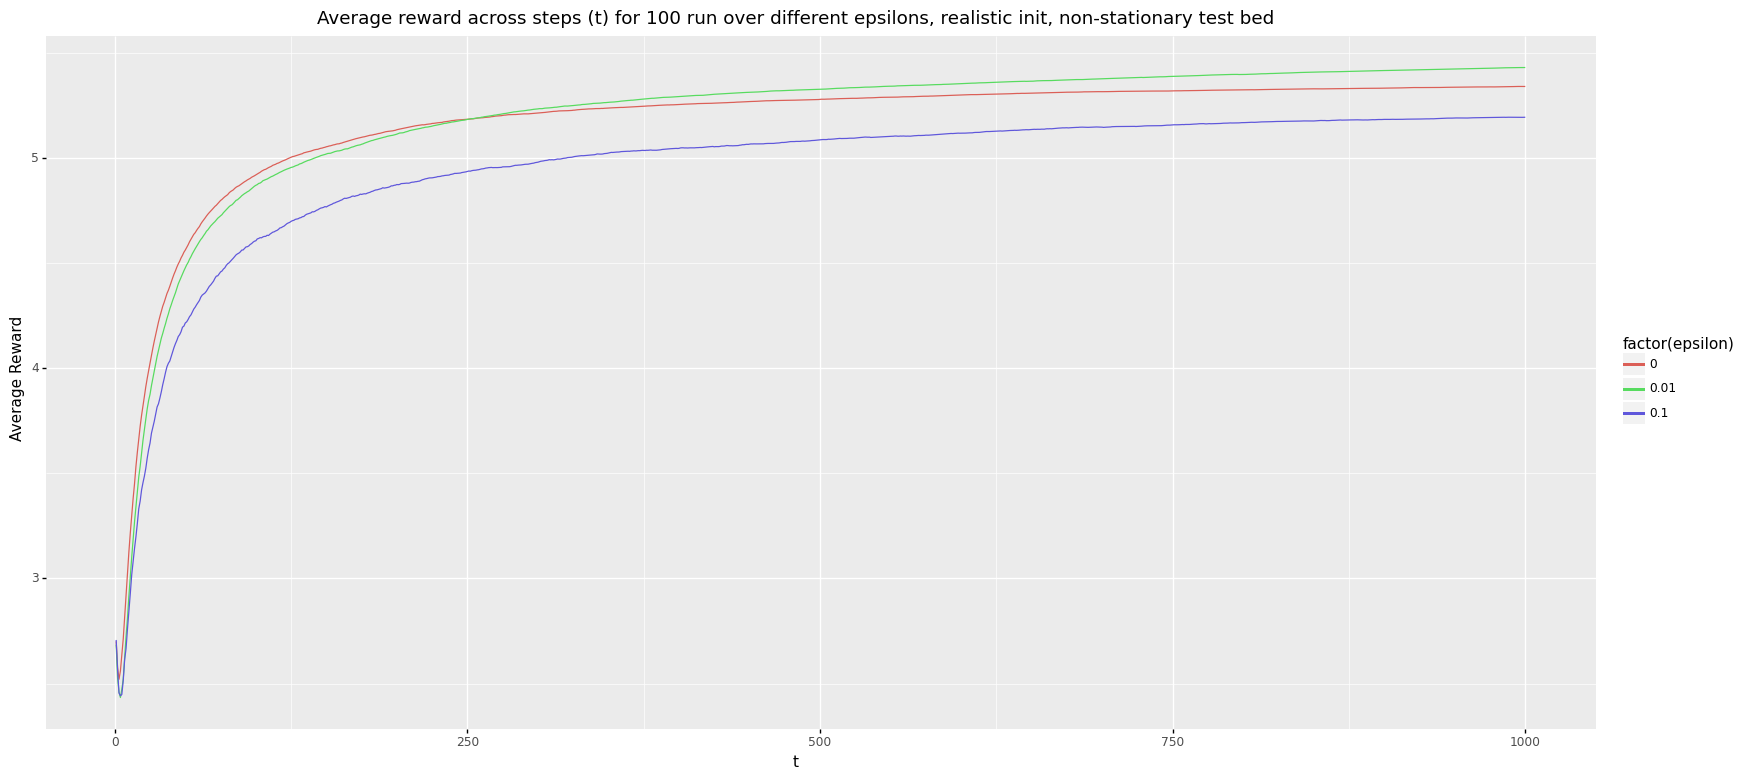

<ggplot: (8740648844365)>

In [190]:
(
    p9.ggplot(Ri_mean.reset_index(), p9.aes(x='t', y='Average Reward', color='factor(epsilon)'))
    + p9.ggtitle(f'Average reward across steps (t) for {RUNS} run over different epsilons, realistic init, non-stationary test bed')
    + p9.geom_line()
    + p9.theme(figure_size=(20,9))
)

In [192]:
testbed.expected_values

{1: {'mean': -12.479305144610668, 'var': 1},
 2: {'mean': -0.9877748431098526, 'var': 1},
 3: {'mean': -6.567614639172353, 'var': 1},
 4: {'mean': 8.175514085407267, 'var': 1},
 5: {'mean': 3.5395390836339655, 'var': 1},
 6: {'mean': -4.316853699419466, 'var': 1},
 7: {'mean': -4.630144252327566, 'var': 1},
 8: {'mean': 2.3489361017530963, 'var': 1},
 9: {'mean': 4.242636632723737, 'var': 1},
 10: {'mean': -0.3444401298200477, 'var': 1}}